# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools
import helmholtz.analysis.plots

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [4]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)

# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.310e+00                    4.468e-01    2.925
INFO     1     7.259e-01 (0.555) [0.555]    3.426e-01    2.123 (0.725)
INFO     2     4.208e-01 (0.581) [0.568]    2.928e-01    1.447 (0.681)
INFO     3     2.668e-01 (0.635) [0.590]    2.670e-01    1.011 (0.698)
INFO     4     1.851e-01 (0.695) [0.615]    2.515e-01    0.746 (0.739)
INFO     5     1.397e-01 (0.755) [0.641]    2.409e-01    0.589 (0.789)
INFO     6     1.138e-01 (0.815) [0.668]    2.330e-01    0.496 (0.843)
INFO     7     9.689e-02 (0.852) [0.691]    2.267e-01    0.434 (0.876)
INFO     8     8.543e-02 (0.882) [0.713]    2.214e-01    0.392 (0.904)
INFO     9     7.703e-02 (0.902) [0.731]    2.169e-01    0.360 (0.921)
INFO     10    7.057e-02 (0.916) [0.748]    2.129e-01    0.336 (0.934)
INFO     11    6.545e-02 (0.927) [0.763]    2.093e-01    0.317 (0.943)
INFO     12    6.127e-02 (0.936) [0.776]    2.060e-01    0.301 (0.951)
INFO 

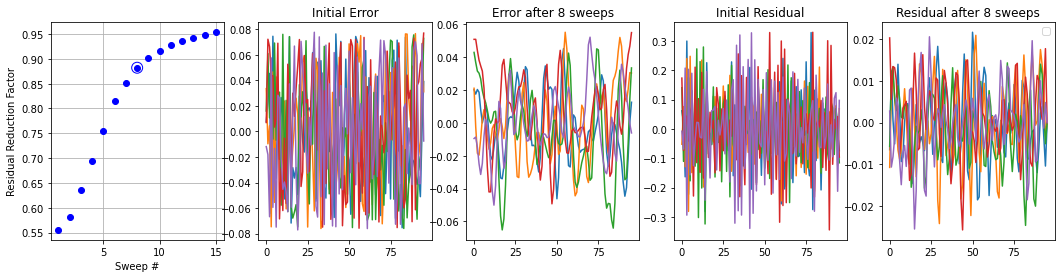

In [5]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

### Coarsening: Fixed (4/2)

In [20]:
# Generate initial test vectors.
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)

# Mock cycle rates.
mock_conv = [hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values]

# Interpolation by LS fitting. Measure 2-level rrates.
calibers = (2, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + mock_conv] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock", ) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

all_conv0 = all_conv

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.108


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.5921,0.3111,0.1987,0.1441,0.1442,0.1305,0.0790,0.0671,0.0645,0.0594,0.0546
P^T A P caliber 2,0.0000,2.0000,192.0000,1.2000,0.0000,0.5405,0.3918,0.4684,0.4931,0.4436,0.4246,0.4289,0.4239,0.4035,0.4031,0.3851
P^T A P caliber 4,0.0000,4.0000,384.0000,2.0000,0.0000,0.5943,0.3317,0.2127,0.1279,0.1519,0.1361,0.1020,0.0747,0.0679,0.0590,0.0531
R A P caliber 2,1.0000,2.0000,192.0000,1.2000,0.0171,0.5467,0.3705,0.4546,0.4845,0.4163,0.4225,0.4225,0.4154,0.3999,0.3944,0.3901
R A P caliber 4,1.0000,4.0000,384.0000,1.2000,0.0040,1.8088,0.4824,0.4430,0.2238,0.2078,0.1543,0.1217,0.0910,0.0567,0.0516,0.0481


## Symmetrizing $R A P$
* First experiment: $R \rightarrow Q$, $P$ stays fixed
$A^c = QAP$ is symmetric and sparse, but not accurate since $P$ is incompatible with $Q$, so 2-level convergence not that great for some random seeds. Even the first few cycles are slow (maybe the first cycle is OK, but that's it).

In [44]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Generate initial test vectors.
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
level = multilevel[0]
x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
_LOGGER.info("Generating {} TVs with {} sweeps RER {:.3f}".format(num_examples, nu, norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

# Generate coarsening.
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)

# Generate high-caliber interpolation, 2-level hierarchy.
caliber = 4
p = hm.setup.auto_setup.create_interpolation(
    x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
    neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
    caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
level, coarse_level = m0[:2]

r = coarse_level._r
p = coarse_level._p
q = hm.repetitive.symmetry.symmetrize(r, level.a.dot(p), num_components, aggregate_size)
_LOGGER.info("|R-Q| {:.3e}".format(norm((r[:2, :4] - q[:2, :4]).todense())))

titles = ("r", "q")
restrictions = (r, q)
l2c = []
slowest_vector = []
for title, restriction in zip(titles, restrictions):
    #print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
    symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
    two_level_result = [
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu_pre=0, nu_post=nu, print_frequency=None, debug=False)
         for nu in nu_values]
    two_level_conv = np.array([row[1] for row in two_level_result])
    slowest_vector.append([row[0] for row in two_level_result])
    l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))

l2c = all_conv0.loc[["Mock"]].values.tolist() + l2c
all_conv = pd.DataFrame(l2c, columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock",) + tuple(titles))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 100 sweeps RER 0.135
INFO     |R-Q| 9.466e-02


,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.5921,0.3111,0.1987,0.1441,0.1442,0.1305,0.0790,0.0671,0.0645,0.0594,0.0546
r,True,4.0000,384.0000,1.2000,0.0099,2.0918,0.5390,0.5051,0.2069,0.2025,0.1586,0.1188,0.0810,0.0558,0.0332,0.0461
q,True,4.0000,384.0000,1.2000,0.0000,142.5433,24.8420,44.4180,10.0353,9.4522,5.2298,4.6624,3.8541,2.4302,1.1805,1.5474


### Stencils

In [45]:
# print("R")
# display(pd.DataFrame(r[:2, :4].todense()))
# print("Q")
# display(pd.DataFrame(q[:2, :4].todense()))
# print("P")
# display(pd.DataFrame(ml[1]._p[6:10, 2:6].todense()))
# print("RAP")
# display(pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))
# print("QAP")
# display(pd.DataFrame(q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense()))

### Slowest Component in Cycle 
After removing the null components.

In [46]:
# fig, axs = plt.subplots(len(nu_values), len(titles), figsize=(10, 4 * len(nu_values)))

# for row, nu in enumerate(nu_values):
#     for col, title in enumerate(titles):
#         y = slowest_vector[col][row].copy()
#         y -= z.dot(z.transpose().dot(y[:, None])).flatten()
#         ax = axs[row][col]
        
#         # Asymptotic vector.
#         ax.set_title("${}, \\nu = {}$".format(title, nu))
#         # y -= y.mean() # Remove zero component.
#         # e = multilevel[1].p.dot(r.dot(y))
#         ax.plot(y, label="x");
#         #ax.plot(e, label="PRx");
#         #ax.grid(True);
#         #ax.legend();

Restriction r
INFO         0 |r| 1.903e+01 RER 3.62013
INFO         1 |r| 2.693e+00 (0.14153) RER 0.00823 (0.00227) 327.327
INFO         2 |r| 1.096e-01 (0.04071) RER 0.00032 (0.03831) 347.851
INFO         3 |r| 6.645e-03 (0.06060) RER 0.00002 (0.06067) 347.473
INFO         4 |r| 4.131e-04 (0.06216) RER 0.00000 (0.06216) 347.495
INFO         5 |r| 2.698e-05 (0.06532) RER 0.00000 (0.06532) 347.493
INFO         6 |r| 1.555e-06 (0.05762) RER 0.00000 (0.05762) 347.492
INFO         7 |r| 1.163e-07 (0.07480) RER 0.00000 (0.07480) 347.492
INFO         8 |r| 9.183e-09 (0.07897) RER 0.00000 (0.07897) 347.492
INFO         9 |r| 7.269e-10 (0.07915) RER 0.00000 (0.07915) 347.492
INFO        10 |r| 6.200e-11 (0.08529) RER 0.00000 (0.08529) 347.492
Restriction q
INFO         0 |r| 1.848e+01 RER 3.35329
INFO         1 |r| 5.411e+01 (2.92763) RER 0.00100 (0.00030) 54112.227
INFO         2 |r| 2.184e+02 (4.03632) RER 0.00118 (1.18240) 184720.602
INFO         3 |r| 8.028e+02 (3.67574) RER 0.00122 (1.029

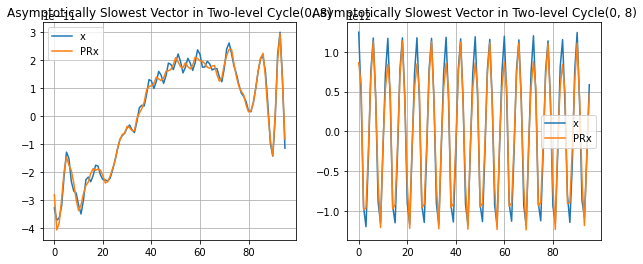

In [47]:
# Example: fixed nu.
nu = 8
fig, axs = plt.subplots(1, len(titles), figsize=(10, 4))

for title, restriction, ax in zip(titles, restrictions, axs):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    y, _ = hm.repetitive.locality.two_level_conv_factor(
                ml, nu_pre=0, nu_post=nu, print_frequency=1)
    y -= z.dot(z.transpose().dot(y[:, None])).flatten()

    # Asymptotic vector.
    ax.set_title("Asymptotically Slowest Vector in Two-level Cycle(0, {})".format(nu))
    e = ml[1].interpolate(r.dot(y))
    ax.plot(y, label="x");
    ax.plot(e, label="PRx");
    ax.grid(True);
    ax.legend();